In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [123]:
class Warehouse():
    def __init__(self):
        self.shops = []
        self.storage = 0
        self.log = pd.DataFrame(columns=["Day","storeId","itemAge","sumItem","overBuy"])
        self.dayCount = 1
    def addShop(self,shop):
        self.shops.append(shop)
        
    def one_day(self):
        order_sum = sum([x.ordered_amount for x in self.shops])
        if(self.storage >= order_sum):
            for shop in self.shops:
                shop.one_day(shop.ordered_amount)
            self.storage -= order_sum
        else:
            for shop in self.shops:
                shop.one_day(round(self.storage*(shop.ordered_amount/order_sum),0))
            self.storage = 0
        self.storage = sum([shop.avg for shop in self.shops])
        
        #LOGGING
        for shop in self.shops:
            self.log = self.log.append({
                "Day" : self.dayCount, 
                "storeId" : shop.id, 
                "itemAge" : 0 if shop.storage[-1] == 0 else len(shop.storage),
                "sumItem" : sum(shop.storage),
                "overBuy" : -shop.overbuy},
                    ignore_index=True)
        self.dayCount += 1

class Shop():
    def __init__(self,avg,std, id):
        self.id = id
        self.avg = avg
        self.std = std
        self.overbuy = 0
        self.ordered_amount = 0
        self.storage = [10]
        
    def get_sold_amount(self):
        return round(np.random.normal(self.avg, self.std, 1)[0],0)
    
    def update_storage(self):
        bought_amount = self.get_sold_amount()
        for index in range(len(self.storage)):
            bought_amount -= self.storage[index]
            if(bought_amount >= 0):
                self.storage[index] = 0
            else:
                self.storage[index] = (-1)*bought_amount
                bought_amount = 0
                break
            
        print(bought_amount,end=" ")
        return bought_amount
            
    def one_day(self,received):
        self.storage.insert(0,received) #upadate storage
        print(self.storage,end=" ")
        self.overbuy = self.update_storage()
        self.ordered_amount = self.avg-sum(self.storage)
        if(self.ordered_amount<0):
            self.ordered_amount = 0
        while(self.storage[-1] == 0 and len(self.storage) > 1):
            self.storage.pop()
        print(self.storage)
        

In [124]:
w = Warehouse()
w.addShop(Shop(10,5,1))


In [125]:
for _ in range(30):
    w.one_day()

[0, 10] 1.0 [0]
[10, 0] 0 [4.0]
[6.0, 4.0] 1.0 [0]
[10, 0] 0 [1.0]
[9.0, 1.0] 2.0 [0]
[10, 0] 0 [2.0]
[8.0, 2.0] 0 [4.0, 2.0]
[4.0, 4.0, 2.0] 9.0 [0]
[10, 0] 4.0 [0]
[10, 0] 0 [3.0]
[7.0, 3.0] 0.0 [0]
[10, 0] 7.0 [0]


C:\Users\bujge\AppData\Local\Temp\ipykernel_17436\2010377203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.log = self.log.append({
C:\Users\bujge\AppData\Local\Temp\ipykernel_17436\2010377203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.log = self.log.append({
C:\Users\bujge\AppData\Local\Temp\ipykernel_17436\2010377203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.log = self.log.append({
C:\Users\bujge\AppData\Local\Temp\ipykernel_17436\2010377203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.log = self.log.append({
C:\Users\bujge\AppData\Local\Temp\ipykernel_17436\2010377203.py:24: Futu

[10, 0] 4.0 [0]
[10, 0] 0 [1.0]
[9.0, 1.0] 1.0 [0]
[10, 0] 0 [7.0]
[3.0, 7.0] 0.0 [0]
[10, 0] 2.0 [0]
[10, 0] 0 [1.0]
[9.0, 1.0] 3.0 [0]
[10, 0] 0 [10.0]
[0.0, 10.0] 1.0 [0]
[10, 0] 2.0 [0]
[10, 0] 2.0 [0]


C:\Users\bujge\AppData\Local\Temp\ipykernel_17436\2010377203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.log = self.log.append({
C:\Users\bujge\AppData\Local\Temp\ipykernel_17436\2010377203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.log = self.log.append({
C:\Users\bujge\AppData\Local\Temp\ipykernel_17436\2010377203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.log = self.log.append({
C:\Users\bujge\AppData\Local\Temp\ipykernel_17436\2010377203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.log = self.log.append({
C:\Users\bujge\AppData\Local\Temp\ipykernel_17436\2010377203.py:24: Futu

[10, 0] 0 [11.0]
[0, 11.0] 0 [0, 5.0]
[5.0, 0, 5.0] 3.0 [0]
[10, 0] 0 [1.0]
[9.0, 1.0] 0 [1.0, 1.0]
[8.0, 1.0, 1.0] 2.0 [0]


C:\Users\bujge\AppData\Local\Temp\ipykernel_17436\2010377203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.log = self.log.append({
C:\Users\bujge\AppData\Local\Temp\ipykernel_17436\2010377203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.log = self.log.append({
C:\Users\bujge\AppData\Local\Temp\ipykernel_17436\2010377203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.log = self.log.append({
C:\Users\bujge\AppData\Local\Temp\ipykernel_17436\2010377203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.log = self.log.append({
C:\Users\bujge\AppData\Local\Temp\ipykernel_17436\2010377203.py:24: Futu

In [126]:
w.log

,Day,storeId,itemAge,sumItem,overBuy
0,1.0,1.0,0.0,0.0,-1.0
1,2.0,1.0,1.0,4.0,0.0
2,3.0,1.0,0.0,0.0,-1.0
3,4.0,1.0,1.0,1.0,0.0
4,5.0,1.0,0.0,0.0,-2.0
5,6.0,1.0,1.0,2.0,0.0
6,7.0,1.0,2.0,6.0,0.0
7,8.0,1.0,0.0,0.0,-9.0
8,9.0,1.0,0.0,0.0,-4.0
9,10.0,1.0,1.0,3.0,0.0


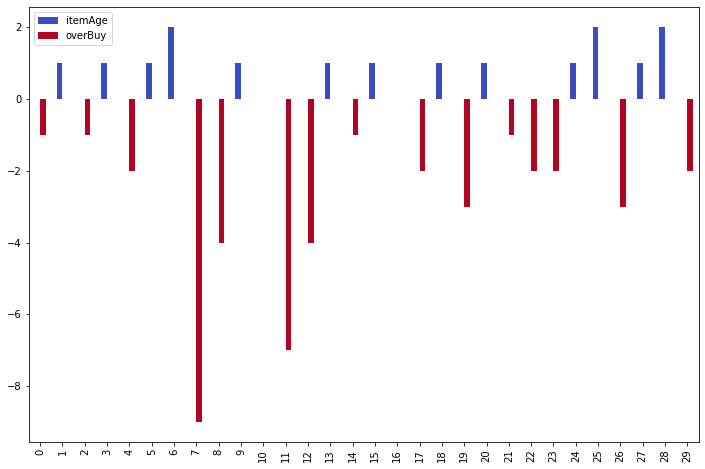

In [127]:
ax = w.log[['itemAge', 'overBuy']].plot(kind='bar', figsize=(12, 8), colormap='coolwarm')
plt.show()

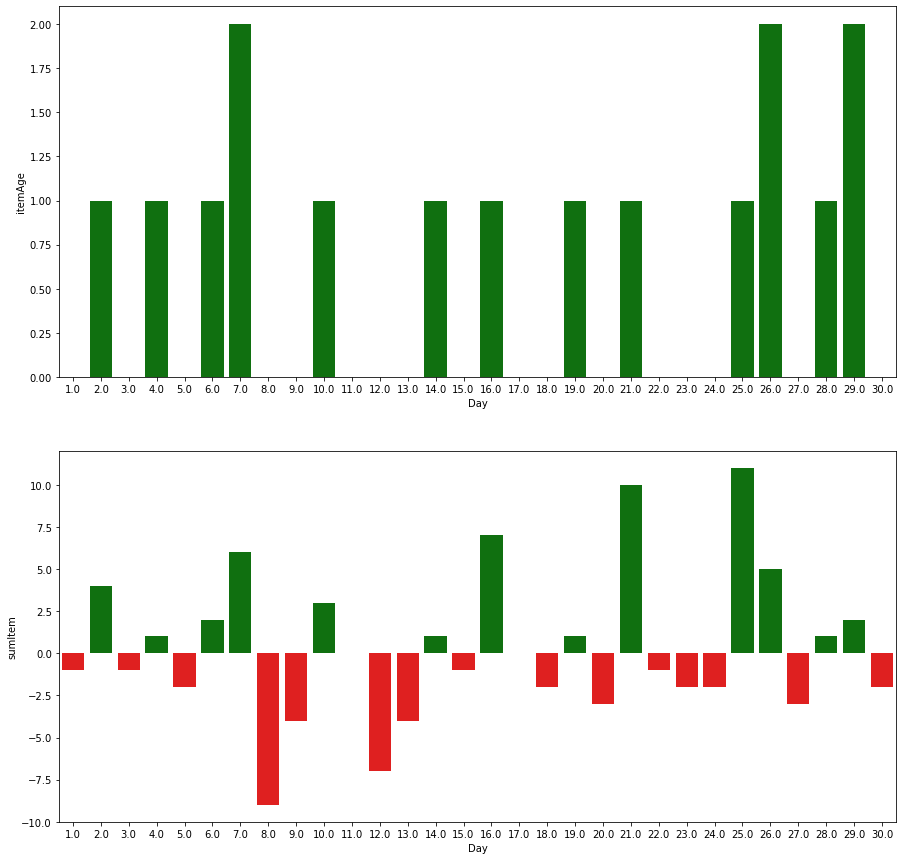

In [133]:
fig, axes = plt.subplots(2)
fig.set_figheight(15)
fig.set_figwidth(15)
sns.barplot(data=w.log,x="Day",y="itemAge",color="green", ax= axes[0])
sns.barplot(data=w.log,x="Day",y="overBuy",color="red", ax= axes[1])
sns.barplot(data=w.log,x ="Day", y="sumItem",color="green", ax= axes[1])

plt.show()